In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].astype('float32').reshape(28, 28) / 255.0
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the MNIST data from an online source using fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data  # Features
y = mnist.target.astype('int64')  # Labels converted to integers

# Create train, val, test splits
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(0.2/0.9), random_state=42)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create Dataset objects
trainset = MNISTDataset(X_train, y_train, transform=transform)
valset = MNISTDataset(X_val, y_val, transform=transform)
testset = MNISTDataset(X_test, y_test, transform=transform)

# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Verify the data shapes
for images, labels in trainloader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


## Creating kolmogorov arnold network

In [6]:
import torch
import torch.nn.functional as F
import math

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)
        splines = splines.permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight
        orig_coeff = orig_coeff.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )


## Initialization of network

Input Layer is 784 i.e. 28 x 28 which is dimension of image <br>
Hidden layer is 2 x input_layer+1 i.e. 1569 <br>
Output layer is 10 for all digits

In [10]:
model = KAN([28 * 28, 28 * 28 * 2 + 1, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

KAN(
  (layers): ModuleList(
    (0-1): 2 x KANLinear(
      (base_activation): SiLU()
    )
  )
)

Defining Optimizer and Learning Rate Decay

In [13]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [15]:
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

## training of Network

In [18]:
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False
num_epochs = 20

for epoch in range(num_epochs):
    if early_stop:
        break
    
    model.train()
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == labels).float().mean()
            epoch_train_loss += loss.item()
            epoch_train_accuracy += accuracy.item()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
    
    epoch_train_loss /= len(trainloader)
    epoch_train_accuracy /= len(trainloader)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    model.eval()
    val_loss = 0
    val_accuracy = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            output = model(images)
            val_loss += criterion(output, labels).item()
            val_accuracy += (output.argmax(dim=1) == labels).float().mean().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(output.argmax(dim=1).cpu().numpy())

    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    print(f"Epoch {epoch + 1}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == patience:
        print("Early stopping!")
        early_stop = True

100%|██████████| 766/766 [00:12<00:00, 60.75it/s, accuracy=0.974, loss=0.156, lr=0.001] 


Epoch 1, Train Loss: 0.2836916991327123, Train Accuracy: 0.9133762845638216, Val Loss: 0.13127219526428882, Val Accuracy: 0.9619720319634704


100%|██████████| 766/766 [00:12<00:00, 61.06it/s, accuracy=0.974, loss=0.0575, lr=0.0008]


Epoch 2, Train Loss: 0.09457271309647292, Train Accuracy: 0.9712866957909756, Val Loss: 0.08644752100654389, Val Accuracy: 0.972531392694064


100%|██████████| 766/766 [00:12<00:00, 61.19it/s, accuracy=1, loss=0.00627, lr=0.00064]   


Epoch 3, Train Loss: 0.049766937635204324, Train Accuracy: 0.9847217689295039, Val Loss: 0.08852276457558687, Val Accuracy: 0.9714611872146118


100%|██████████| 766/766 [00:12<00:00, 61.35it/s, accuracy=0.974, loss=0.034, lr=0.000512] 


Epoch 4, Train Loss: 0.025579224319796638, Train Accuracy: 0.9926435822139521, Val Loss: 0.0673651132332884, Val Accuracy: 0.98087899543379


100%|██████████| 766/766 [00:12<00:00, 61.33it/s, accuracy=1, loss=0.00315, lr=0.00041]   


Epoch 5, Train Loss: 0.010929871830170093, Train Accuracy: 0.9980213772845953, Val Loss: 0.05869725592791626, Val Accuracy: 0.983019406392694


100%|██████████| 766/766 [00:12<00:00, 61.35it/s, accuracy=1, loss=0.00329, lr=0.000328]   


Epoch 6, Train Loss: 0.004959887120362545, Train Accuracy: 0.999490045691906, Val Loss: 0.06150797645898417, Val Accuracy: 0.981949200913242


100%|██████████| 766/766 [00:12<00:00, 60.73it/s, accuracy=1, loss=0.000442, lr=0.000262]  


Epoch 7, Train Loss: 0.00275776656798188, Train Accuracy: 0.9996940274151436, Val Loss: 0.056510317171886607, Val Accuracy: 0.9840182648401826


100%|██████████| 766/766 [00:12<00:00, 60.90it/s, accuracy=1, loss=0.00162, lr=0.00021]   


Epoch 8, Train Loss: 0.0014782099766573473, Train Accuracy: 0.9999388054830287, Val Loss: 0.058705439810087204, Val Accuracy: 0.9840896118721462


100%|██████████| 766/766 [00:12<00:00, 60.71it/s, accuracy=1, loss=0.000353, lr=0.000168]  


Epoch 9, Train Loss: 0.001027748344899836, Train Accuracy: 0.9999796018276762, Val Loss: 0.05796572375196334, Val Accuracy: 0.9839469178082192


100%|██████████| 766/766 [00:12<00:00, 61.01it/s, accuracy=1, loss=0.000983, lr=0.000134]


Epoch 10, Train Loss: 0.0007756593244000735, Train Accuracy: 1.0, Val Loss: 0.058554592213503585, Val Accuracy: 0.9838042237442922
Early stopping!


## training Plot of Network

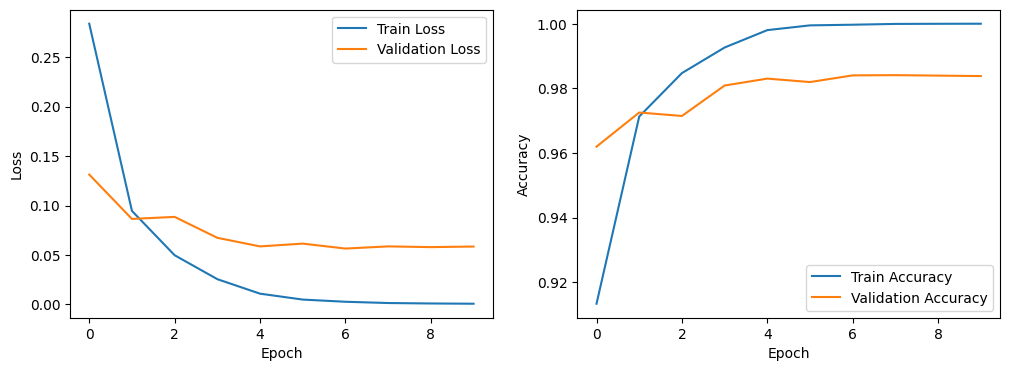

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Confusion Matrix Plot

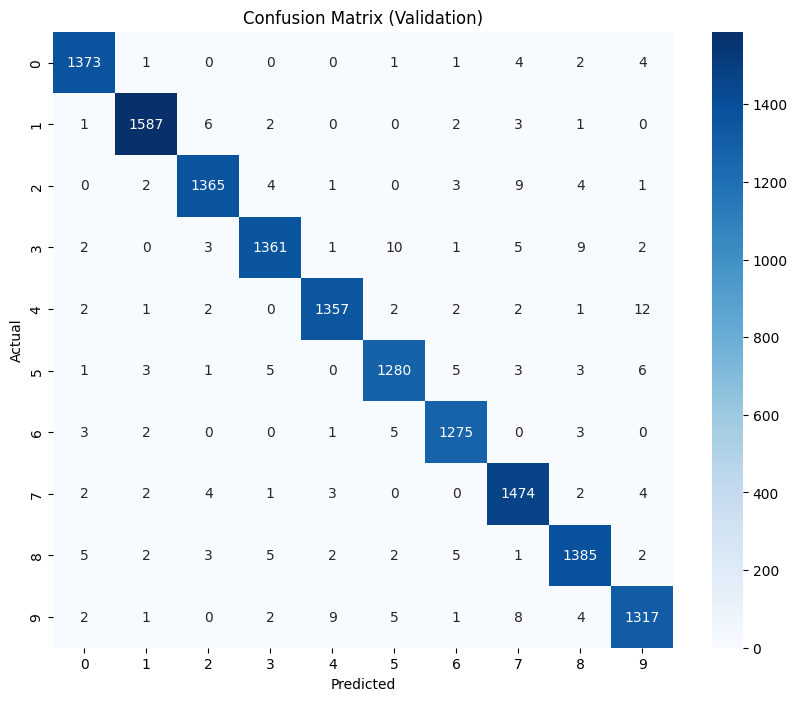

In [23]:
class_labels = np.arange(10)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation)')
plt.show()

In [25]:
model.eval()
test_loss = 0
test_accuracy = 0
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for images, labels in testloader:
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)
        output = model(images)
        test_loss += criterion(output, labels).item()
        test_accuracy += (output.argmax(dim=1) == labels).float().mean().item()
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(output.argmax(dim=1).cpu().numpy())

test_loss /= len(testloader)
test_accuracy /= len(testloader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.07362991729089778, Test Accuracy: 0.9785984852097251


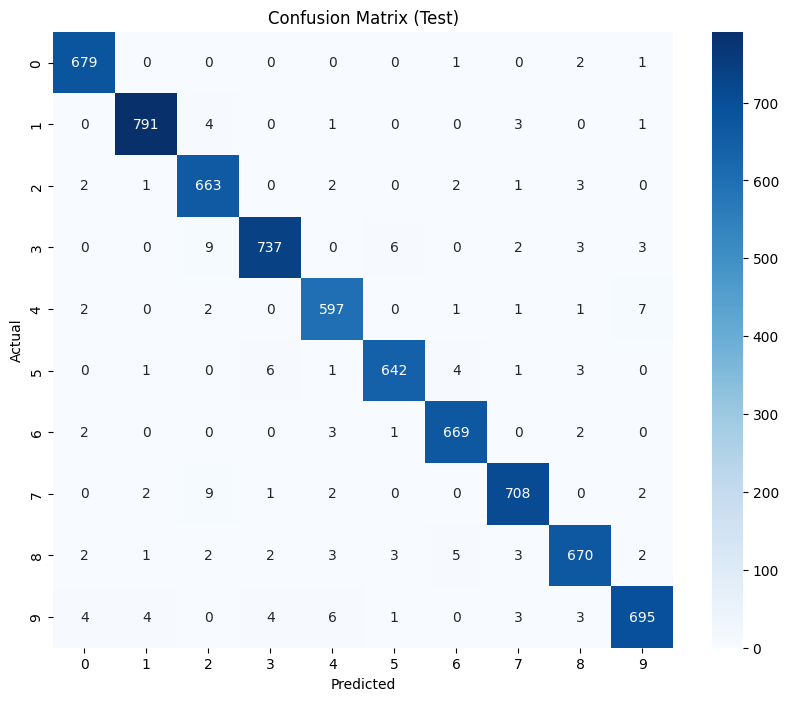

In [27]:
cm_test = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')
plt.show()